In [1]:
import torch
from Nets import NetTaskIL
from functions import test
from dataloaders.mnist import MNIST_for_classes_TaskIL, MNIST
from dataloaders.noise import dataloader_pretraining_gray
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

torch.cuda.is_available()
device = 'cuda'

In [2]:
import torch.nn.functional as F

def train_validation_all_classes(model, optimizer, tasks, rehersal_loader, epoch=1, log_interval = 1000):
    train_losses = []
    tasks_losses = [[], [], [], [], []]
    exemplers = []

    rehersal_iterator = iter(rehersal_loader)

    model.train()
    for taskNo in range(len(tasks)):
        for batch_idx, (data, target) in enumerate(tasks[taskNo]):
            exemplers.append(tasks[taskNo].batch_size * batch_idx)
            rehersal_data = next(rehersal_iterator)

            optimizer.zero_grad()
            output = model(taskNo, data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
            output = model(taskNo, rehersal_data[0])
            loss = F.cross_entropy(output, rehersal_data[1])
            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                print(f"Train [{batch_idx * len(data)} / {len(tasks[taskNo].dataset)}]       loss: {loss.item()}")
                for i in range(len(tasks)):
                    tasks_losses[i].append(test(model, tasks[i], i, print_accuracy=False))

            train_losses.append(loss.item())
    return train_losses, tasks_losses, exemplers

def test(model, test_loader, taskNo, print_accuracy=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(taskNo, data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    if print_accuracy:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [3]:
task1 = MNIST_for_classes_TaskIL(0, 1)
task2 = MNIST_for_classes_TaskIL(2, 3)
task3 = MNIST_for_classes_TaskIL(4, 5)
task4 = MNIST_for_classes_TaskIL(6, 7)
task5 = MNIST_for_classes_TaskIL(8, 9)

tasks = [task1 ,task2, task3, task4, task5]

_, _, test_loader = MNIST()

rehersal_loader = dataloader_pretraining_gray("dead_leaves-mixed", no_classes=2)

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Loading data from data/dead_leaves-mixed/ as imagefolder


In [10]:
torch.randint(2,(1,))[0]

tensor(1)

In [4]:
rehersal_iter = iter(rehersal_loader)
next(rehersal_iter)[0]

tensor([[[[0.2824, 0.2980, 0.2980,  ..., 0.6588, 0.6235, 0.6431],
          [0.4431, 0.3647, 0.2196,  ..., 0.6510, 0.6314, 0.6431],
          [0.5529, 0.4784, 0.2784,  ..., 0.6118, 0.6392, 0.6471],
          ...,
          [0.8118, 0.7059, 0.7529,  ..., 0.3725, 0.5412, 0.6588],
          [0.7059, 0.5137, 0.5843,  ..., 0.6745, 0.7412, 0.7529],
          [0.7804, 0.5843, 0.5961,  ..., 0.8235, 0.8392, 0.7843]]],


        [[[0.4392, 0.4431, 0.4706,  ..., 0.6510, 0.6980, 0.7176],
          [0.4745, 0.5451, 0.5882,  ..., 0.6510, 0.6039, 0.5569],
          [0.2706, 0.3020, 0.4784,  ..., 0.6510, 0.6000, 0.5608],
          ...,
          [0.5176, 0.4471, 0.4431,  ..., 0.5098, 0.3176, 0.2980],
          [0.4431, 0.4471, 0.4431,  ..., 0.5843, 0.2549, 0.1059],
          [0.4471, 0.4510, 0.4588,  ..., 0.7569, 0.4941, 0.1216]]],


        [[[0.7176, 0.7176, 0.7176,  ..., 0.4392, 0.4314, 0.4314],
          [0.7176, 0.7176, 0.7176,  ..., 0.4431, 0.4353, 0.4275],
          [0.7176, 0.7176, 0.7176,  ..

In [5]:
next(rehersal_iter)[1]

tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 0])

In [6]:
print('-'*50, 'benchmark normal training', '-'*50)
model = NetTaskIL(10)
optimizer = optim.SGD(model.parameters(), lr=0.1)


train_losses, tasks_losses, exemplers = train_validation_all_classes(model, optimizer, tasks, rehersal_loader, epoch=1, log_interval = 10)

plt.plot(exemplers, train_losses)
# test(model, test_loader)

-------------------------------------------------- benchmark normal training --------------------------------------------------
Train [0 / 12665]       loss: 0.6940789222717285


c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train [1280 / 12665]       loss: 0.6900616884231567
Train [2560 / 12665]       loss: 0.7055810689926147
Train [3840 / 12665]       loss: 0.6954175233840942
Train [5120 / 12665]       loss: 0.6923264265060425
Train [6400 / 12665]       loss: 0.692621111869812
Train [7680 / 12665]       loss: 0.7093278765678406
Train [8960 / 12665]       loss: 0.6833731532096863
Train [10240 / 12665]       loss: 0.7052600979804993
Train [11520 / 12665]       loss: 0.7009573578834534
Train [0 / 12089]       loss: 0.6831538081169128
Train [1280 / 12089]       loss: 0.6811205744743347
Train [2560 / 12089]       loss: 0.6859458088874817
Train [3840 / 12089]       loss: 0.6963041424751282
Train [5120 / 12089]       loss: 0.7003470063209534
Train [6400 / 12089]       loss: 0.6993407607078552


KeyboardInterrupt: 

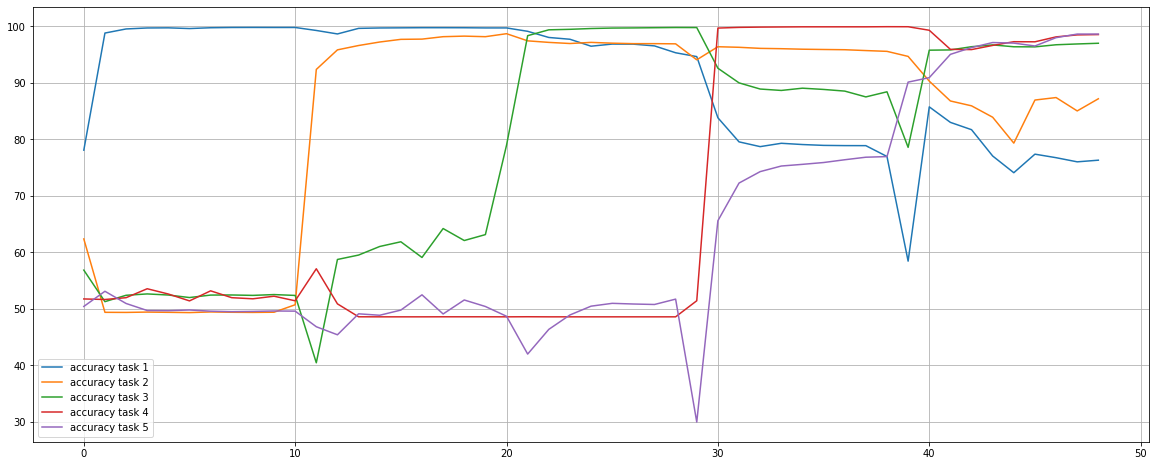

In [ ]:
plt.figure(figsize=(20,8))
for i in range(len(tasks_losses)):
    plt.plot(tasks_losses[i])

plt.legend([f"accuracy task {i+1}" for i in range(len(tasks_losses))])
plt.grid()
plt.show()

In [26]:
77*160

12320

In [ ]:
tasks_acc = tasks_losses

In [ ]:
# import pickle

# with open('taskILMNIST.pkl', 'wb') as f:
#     pickle.dump([tasks_acc, train_losses], f)